<a href="https://colab.research.google.com/github/NikAttano/Classify-Tweets-Based-On-Emotion/blob/main/Recognizing_emotions_in_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup Section

Using Hugging face nlp package

In [1]:
!pip install nlp

### Import required packages and Create helper function for plotting graphs

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

def show_history(h):
  epochs_trained = len(h.history['loss'])
  plt.figure(figsize = (16, 6))

  plt.subplot(1, 2, 1)
  plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label = 'Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label = 'Validation')
  plt.ylim([0., 1.])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)

def show_confusion_matrix(y_true, y_pred, classes):

  from sklearn.metrics import confusion_matrix

  cm = confusion_matrix(y_true, y_pred, normalize = 'true')

  plt.figure(figsize = (8, 8))
  sp = plt.subplot(1, 1, 1)
  ctx = sp.matshow(cm)
  plt.yticks(list(range(0, 6), labels = classes))
  plt.yticks(list(range(0, 6), labels = classes))
  plt.colorbar(ctx)
  plt.show()


### Get the data

Importing the tweet emotion dataset from nlp package

In [3]:
dataset = nlp.load_dataset('emotion')
dataset

Using custom data configuration default


{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

Looking at number of examples for each set

In [4]:
train = dataset['train']
test = dataset['test']
val = dataset['validation']
print('Train    Test    Validation\n')
print(len(train), end = '\t')
print(len(test), end = '\t')
print(len(val), end = '\t')

Train    Test    Validation

16000	2000	2000	

Looking at the examples using a helper function

In [5]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

Look at example from train set

In [6]:
tweets, labels = get_tweet(train)
print('tweet\t\t\tlabel')
print(tweets[0],end = '\t')
print(":", end = ' ')
print(labels[0])

tweet			label
i didnt feel humiliated	: sadness


### Tokenization using preprocessing

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

Visualizong the tokens generated for the tweet

In [8]:
print(tweets[0])
print(tokenizer.texts_to_sequences([tweets[0]]))

i didnt feel humiliated
[[2, 139, 3, 679]]


Checking where the length is most concentrated

(array([  8.,  45., 310., 488., 539., 625., 626., 629., 613., 636., 654.,
        655., 608., 622., 609., 603., 559., 535., 530., 510., 452., 430.,
        382., 385., 330., 327., 336., 317., 238., 208., 200., 200., 167.,
        157., 141., 144., 120., 117., 117.,  88.,  96.,  72.,  66.,  66.,
         65.,  52.,  37.,  43.,  30.,  32.,  31.,  26.,  30.,  20.,  23.,
         14.,   9.,  10.,   4.,   4.,   4.,   1.,   4.,   1.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
        41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
        54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.]),
 <a list of 64 Patch objects>)

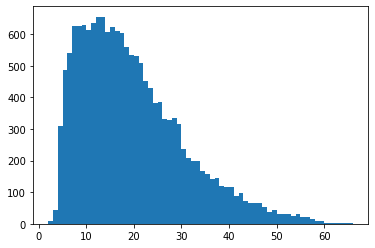

In [9]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))

### Truncating and padding for normalizing length of tweets

Since after 50 length let us truncate the tweets upto50 length and pad the smaller ones to 50 length

In [10]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = maxlen)
  return padded

The zeros seen here is the padding

In [12]:
padded_train_seq = get_sequences(tokenizer, tweets)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Preparing the labels

In [13]:
classes = set(labels)
print(classes)

{'love', 'anger', 'joy', 'surprise', 'fear', 'sadness'}


There is a class imbalance problem with the data

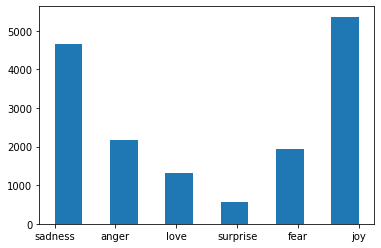

In [14]:
plt.hist(labels, bins = 11)
plt.show()

In [15]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in classes_to_index.items())
print(classes_to_index, end = '\n')
print(index_to_class)

{'love': 0, 'anger': 1, 'joy': 2, 'surprise': 3, 'fear': 4, 'sadness': 5}
{0: 'love', 1: 'anger', 2: 'joy', 3: 'surprise', 4: 'fear', 5: 'sadness'}


In [16]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

The emotion is now represented by a number

In [17]:
train_labels = names_to_ids(labels)
print(train_labels[0])

5


### Creating a sequential model

In [18]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation = 'softmax')
])

model.compile(
    
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


### Training the model

In [20]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [21]:
print(classes_to_index)
val_tweets[0], val_labels[0]


{'love': 0, 'anger': 1, 'joy': 2, 'surprise': 3, 'fear': 4, 'sadness': 5}


('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [22]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 42s 63ms/step - loss: 1.2783 - accuracy: 0.4891 - val_loss: 0.7863 - val_accuracy: 0.6810
Epoch 2/20
500/500 [==============================] - 29s 58ms/step - loss: 0.5527 - accuracy: 0.7890 - val_loss: 0.5263 - val_accuracy: 0.8065
Epoch 3/20
500/500 [==============================] - 30s 59ms/step - loss: 0.2917 - accuracy: 0.9026 - val_loss: 0.4546 - val_accuracy: 0.8510
Epoch 4/20
500/500 [==============================] - 30s 59ms/step - loss: 0.2052 - accuracy: 0.9334 - val_loss: 0.3463 - val_accuracy: 0.8875
Epoch 5/20
500/500 [==============================] - 29s 59ms/step - loss: 0.1481 - accuracy: 0.9536 - val_loss: 0.4331 - val_accuracy: 0.8695
Epoch 6/20
500/500 [==============================] - 29s 59ms/step - loss: 0.1248 - accuracy: 0.9611 - val_loss: 0.3919 - val_accuracy: 0.8955
Epoch 7/20
500/500 [==============================] - 29s 59ms/step - loss: 0.1049 - accuracy: 0.9663 - val_loss: 0.3584 - val_accuracy:

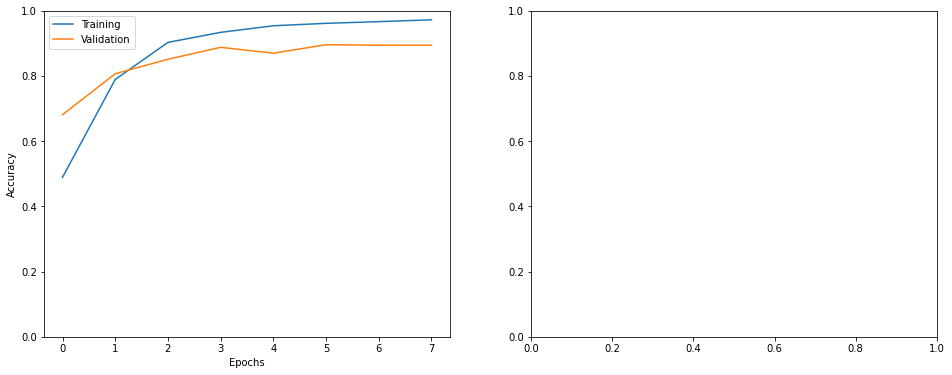

In [23]:
show_history(h)

In [56]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [25]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 21ms/step - loss: 0.3979 - accuracy: 0.8810


In [26]:
print(index_to_class)
i = random.randint(0, len(test_labels)  - 1)
print('Original senetence:', test_tweets[i])
print('original label:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Class:', pred_class)

{0: 'love', 1: 'anger', 2: 'joy', 3: 'surprise', 4: 'fear', 5: 'sadness'}
Original senetence: i feel like that im hated by most of the girls is it becoz im a good dancer
original label: sadness
Predicted Class: anger


In [34]:
import keras

In [57]:
preds = model.predict(test_seq)
pred_classes = preds.argmax(axis = -1)

In [58]:
print(classes)
print(test_labels)
# print(preds)
print(pred_classes)
pred_classes = [index_to_class.get(i) for i in pred_classes]
test_labels = [index_to_class.get(i) for i in test_labels]
# print(pred_classes)
# print(test_labels)

{'love', 'anger', 'joy', 'surprise', 'fear', 'sadness'}
[5 5 5 ... 2 2 4]
[5 5 5 ... 2 2 3]
['sadness', 'sadness', 'sadness', 'joy', 'sadness', 'fear', 'anger', 'joy', 'joy', 'anger', 'anger', 'sadness', 'sadness', 'joy', 'love', 'sadness', 'joy', 'sadness', 'anger', 'joy', 'joy', 'joy', 'joy', 'sadness', 'sadness', 'fear', 'anger', 'sadness', 'fear', 'anger', 'fear', 'anger', 'sadness', 'anger', 'sadness', 'joy', 'love', 'sadness', 'joy', 'joy', 'anger', 'sadness', 'joy', 'sadness', 'joy', 'anger', 'joy', 'joy', 'fear', 'surprise', 'sadness', 'fear', 'joy', 'sadness', 'joy', 'sadness', 'sadness', 'joy', 'sadness', 'anger', 'sadness', 'sadness', 'love', 'joy', 'sadness', 'surprise', 'sadness', 'anger', 'surprise', 'surprise', 'joy', 'love', 'fear', 'joy', 'joy', 'anger', 'joy', 'sadness', 'joy', 'love', 'joy', 'anger', 'sadness', 'joy', 'sadness', 'sadness', 'joy', 'joy', 'joy', 'sadness', 'joy', 'fear', 'anger', 'surprise', 'anger', 'anger', 'joy', 'joy', 'anger', 'sadness', 'fear', '

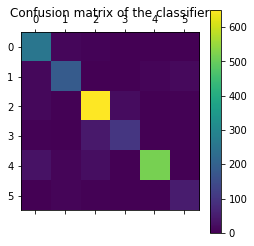

In [59]:
from sklearn.metrics import confusion_matrix
import pylab as pl
cm = confusion_matrix(test_labels, pred_classes)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

### Final Confusion Matrix

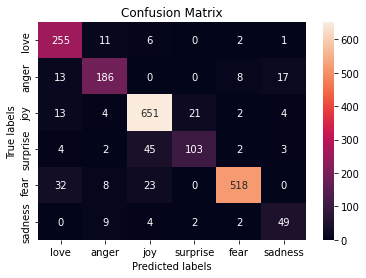

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);